# Creating Dataset to be used in a DataStudio Dashboard

# Expanding the measurement of culture with a sample of two billion humans

## Replication Data and Code

This notebook provides all the steps to replicate the results of our paper [Expanding the measurement of culture with a sample of two billion humans](https://doi.org/10.1098/rsif.2022.0085) published in the *Journal of the Royal Society Interface 19:20220085* (2022).

# Setup and Pre-requisites

Let's start by importing the required packages

In [1]:
#%pylab --no-import-all
%matplotlib inline

import sys, os, time
import numpy as np
import pandas as pd
pd.set_option('display.width', 160)
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, manhattan_distances, pairwise_distances
from scipy.stats import zscore
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import spatial, stats
from scipy.stats import zscore
import MantelTest.MantelTest as MantelTest
import re
import seaborn as sns
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')
mapper4 = country(from_key='iso', to_key='name')

Let's setup our paths

In [2]:
pathfb = './data/'
pathfbor = './data/OriginalData/'
pathregs = pathfb + 'Regs/'
pathsamples = pathfb + '/DemographicData/'  

pathout = pathregs + 'Categories/'
if os.path.exists(pathout) == False:
    os.mkdir(pathout)
pathshare = pathout
if os.path.exists(pathfbor) == False:
    os.mkdir(pathfbor)

## Import Data

## Merge all the category distances and compare them to original FB and other measures

In [3]:
mycats = [f[f.find('_')+1:f.find('.')] for f in os.listdir(pathout) if f.endswith('dta')]
mycats.sort()
mycats

['BusinessIndustry',
 'Education',
 'Empty',
 'FamilyRelationships',
 'FitnessWellness',
 'FoodDrink',
 'HobbiesActivities',
 'LifestyleCulture',
 'NewsEntertainment',
 'NonLocalBus',
 'People',
 'ShoppingFashion',
 'SportsOutdoors',
 'Technology',
 'TravelPlacesEvents']

In [4]:
# Type of distance measure
m = 'Cos'

# Load data other distances  
df = pd.read_stata(pathregs + 'AllDistsFull.dta')

for c in mycats:
    fbdist2 = pd.read_stata(pathout + 'FB' + m + 'Dist_' + c + '.dta')
    cols = fbdist2.columns.tolist()
    cols[0] = 'ISO_CODE_1'
    fbdist2.columns = cols
    fbdist2 = fbdist2.set_index('ISO_CODE_1').stack().copy()
    fbdist2 = fbdist2.reset_index()
    fbdist2.columns = ['ISO_CODE_1', 'ISO_CODE_2', 'FBDist_'+c]
    df = df.merge(fbdist2, on=['ISO_CODE_1', 'ISO_CODE_2'], how='left')

In [5]:
df.head()

,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,CosDist7,CosDist8,...,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,AD,AD,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,AD,AE,0.649726,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
2,AD,AF,0.027777,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
3,AD,AG,0.298230,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
4,AD,AI,0.917672,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484


In [6]:
df[[c for c in df.columns if c.startswith('FB')]].head()

,FBDist,FBDist_BusinessIndustry,FBDist_Education,FBDist_Empty,FBDist_FamilyRelationships,FBDist_FitnessWellness,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.233552,0.288817,0.189267,0.174565,0.153039,0.132261,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
2,0.279233,0.314991,0.340453,0.207937,0.298100,0.226512,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
3,0.227161,0.279893,0.282477,0.154556,0.135234,0.133760,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
4,0.262021,0.288825,0.347721,0.213974,0.205464,0.188594,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484


In [7]:
# Import all distances
mypairs = pd.read_stata(pathregs + 'AllDists.dta')

# Merge category distances
mypairs = mypairs.merge(df[df.columns.difference(mypairs.columns).tolist() + ['ISO_CODE_1', 'ISO_CODE_2']], how='left', on=['ISO_CODE_1', 'ISO_CODE_2'])
mypairs.drop([x for x in mypairs.columns if x.endswith('uk') or x.endswith('usa')], inplace=True, axis=1)
mypairs.drop([x for x in mypairs.columns if x.find('cognate')!=-1], inplace=True, axis=1)

In [8]:
mypairs

,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,CosDist7,CosDist8,...,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,AD,AE,0.649726,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
1,AD,AF,0.027777,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
2,AD,AG,0.298230,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
3,AD,AI,0.917672,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484
4,AD,AL,0.002674,0.998614,0.998062,1.000000,0.999967,1.000000,1.000000,1.000000,...,0.158682,0.203463,0.211969,0.104971,0.221430,0.672669,0.115245,0.234657,0.088875,0.511526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27490,YT,ZM,0.078120,0.078460,0.078460,0.078427,0.078427,0.078427,0.078427,0.078427,...,0.314180,0.264914,0.104575,0.053099,0.202428,0.674473,0.142165,0.317044,0.112804,0.425856
27491,YT,ZW,0.078103,0.078497,0.078497,0.078497,0.078497,0.078497,0.078497,0.078497,...,0.342396,0.293738,0.078400,0.051409,0.185660,0.752413,0.130497,0.398470,0.089990,0.391816
27492,ZA,ZM,0.042589,0.040391,0.040391,0.021715,0.021725,0.021725,0.021725,0.021725,...,0.131968,0.114329,0.076315,0.018861,0.104667,0.293089,0.065884,0.149984,0.051544,0.296675
27493,ZA,ZW,0.042107,0.039633,0.039633,0.021641,0.021641,0.021641,0.021641,0.021641,...,0.115236,0.112350,0.056001,0.023694,0.100517,0.430028,0.076627,0.208669,0.043190,0.263977


In [9]:
mypairs['Origin Country'] = mypairs.ISO_CODE_1.apply(mapper4)
mypairs['Destination Country'] = mypairs.ISO_CODE_2.apply(mapper4)

In [10]:
mypairs = mypairs[['Origin Country', 'Destination Country'] + mypairs.columns.tolist()[:-2]]
mypairs.head()

,Origin Country,Destination Country,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,...,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,Andorra,United Arab Emirates,AD,AE,0.649726,1.000000,1.000000,1.0,1.000000,1.0,...,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
1,Andorra,Afghanistan,AD,AF,0.027777,1.000000,1.000000,1.0,1.000000,1.0,...,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
2,Andorra,Antigua and Barbuda,AD,AG,0.298230,1.000000,1.000000,1.0,1.000000,1.0,...,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
3,Andorra,Anguilla,AD,AI,0.917672,1.000000,1.000000,1.0,1.000000,1.0,...,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484
4,Andorra,Albania,AD,AL,0.002674,0.998614,0.998062,1.0,0.999967,1.0,...,0.158682,0.203463,0.211969,0.104971,0.221430,0.672669,0.115245,0.234657,0.088875,0.511526


In [11]:
mypairs[mypairs.columns.tolist()[:4] + [c for c in mypairs.columns if c.startswith('FB')]].head()

,Origin Country,Destination Country,ISO_CODE_1,ISO_CODE_2,FBDist,FBDist_BusinessIndustry,FBDist_Education,FBDist_Empty,FBDist_FamilyRelationships,FBDist_FitnessWellness,FBDist_FoodDrink,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents
0,Andorra,United Arab Emirates,AD,AE,0.233552,0.288817,0.189267,0.174565,0.153039,0.132261,0.178210,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951
1,Andorra,Afghanistan,AD,AF,0.279233,0.314991,0.340453,0.207937,0.298100,0.226512,0.294734,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510
2,Andorra,Antigua and Barbuda,AD,AG,0.227161,0.279893,0.282477,0.154556,0.135234,0.133760,0.251972,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606
3,Andorra,Anguilla,AD,AI,0.262021,0.288825,0.347721,0.213974,0.205464,0.188594,0.261493,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484
4,Andorra,Albania,AD,AL,0.216498,0.225739,0.192321,0.153686,0.073003,0.129123,0.158682,0.203463,0.211969,0.104971,0.221430,0.672669,0.115245,0.234657,0.088875,0.511526


In [12]:
df.shape

(55225, 69)

In [13]:
mypairs.shape

(27495, 63)

In [14]:
df['same'] = (df.ISO_CODE_1==df.ISO_CODE_2).astype(int)

In [15]:
df['Origin Country'] = df.ISO_CODE_1.apply(mapper4)
df['Destination Country'] = df.ISO_CODE_2.apply(mapper4)

In [16]:
df = df[['Origin Country', 'Destination Country'] + df.columns.tolist()[:-2]]
df.head()

,Origin Country,Destination Country,ISO_CODE_1,ISO_CODE_2,CosDist1,CosDist2,CosDist3,CosDist4,CosDist5,CosDist6,...,FBDist_HobbiesActivities,FBDist_LifestyleCulture,FBDist_NewsEntertainment,FBDist_NonLocalBus,FBDist_People,FBDist_ShoppingFashion,FBDist_SportsOutdoors,FBDist_Technology,FBDist_TravelPlacesEvents,same
0,Andorra,Andorra,AD,AD,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,Andorra,United Arab Emirates,AD,AE,0.649726,1.0,1.0,1.0,1.0,1.0,...,0.256747,0.186337,0.083852,0.245167,0.733101,0.133534,0.283705,0.099948,0.519951,0
2,Andorra,Afghanistan,AD,AF,0.027777,1.0,1.0,1.0,1.0,1.0,...,0.298884,0.272084,0.124117,0.291968,0.832636,0.165568,0.377505,0.117173,0.531510,0
3,Andorra,Antigua and Barbuda,AD,AG,0.298230,1.0,1.0,1.0,1.0,1.0,...,0.258350,0.154459,0.099079,0.234904,0.680631,0.143881,0.376967,0.085136,0.504606,0
4,Andorra,Anguilla,AD,AI,0.917672,1.0,1.0,1.0,1.0,1.0,...,0.279948,0.195226,0.153596,0.263495,0.651478,0.164097,0.371870,0.081088,0.506484,0


In [17]:
df.set_index(df.columns.tolist()[:1], inplace=True)

In [18]:
df.groupby(level=0).FBDist.mean()

Origin Country
Afghanistan          0.251204
Albania              0.229590
Algeria              0.203205
American Samoa       0.270945
Andorra              0.244827
                       ...   
Vietnam              0.300195
Wallis and Futuna    0.500607
Yemen                0.228066
Zambia               0.205705
Zimbabwe             0.212998
Name: FBDist, Length: 235, dtype: float64

In [19]:
df['FBDist_mean'] = df.groupby(level=0).FBDist.mean()

array([[<AxesSubplot:title={'center':'FBDist_mean'}>]], dtype=object)

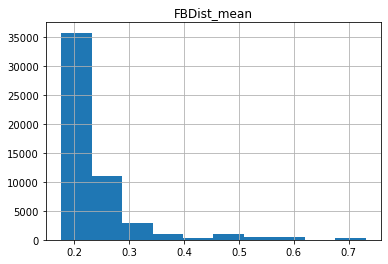

In [20]:
df[['FBDist_mean']].hist()

In [22]:
df.reset_index(inplace=True)

In [23]:
drop_dash = list(df.loc[(df.FBDist_mean>0.32), 'Origin Country'].unique())
drop_dash.remove('Turkmenistan')
drop_dash

['Bonaire, Saint Eustatius and Saba ',
 'Cook Islands',
 'Eritrea',
 'Liechtenstein',
 'Monaco',
 'Saint Martin',
 'Montserrat',
 'Nauru',
 'Niue',
 'Saint Pierre and Miquelon',
 'Palau',
 'San Marino',
 'Tokelau',
 'Tuvalu',
 'British Virgin Islands',
 'Wallis and Futuna']

In [24]:
df['drop_dash'] = (df['Origin Country'].isin(drop_dash)) | (df['Destination Country'].isin(drop_dash))

In [25]:
df.to_csv(pathregs + 'FBDists_dashboard.csv', index=False, encoding='utf=8')

In [26]:
df.loc[(df.ISO_CODE_1=='CO') & (df.ISO_CODE_2=='US'), ['FBDist']]

,FBDist
10557,0.144988


In [27]:
df.FBDist.max()

0.9065142607107856